In [1]:
# Inspiration: https://www.kaggle.com/code/aresca/tfm-armando-espinoza/notebook

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("household_electricity_data.csv")
data.head()

,num_rooms,num_people,housearea,is_ac,is_tv,is_flat,ave_monthly_income,num_children,is_urban,amount_paid
0,3,3,742.57,1,1,1,9675.93,2,0,560.481447
1,1,5,952.99,0,1,0,35064.79,1,1,633.283679
2,3,1,761.44,1,1,1,22292.44,0,0,511.879157
3,0,5,861.32,1,1,0,12139.08,0,0,332.992035
4,1,8,731.61,0,1,0,17230.10,2,1,658.285625


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num_rooms           1000 non-null   int64  
 1   num_people          1000 non-null   int64  
 2   housearea           1000 non-null   float64
 3   is_ac               1000 non-null   int64  
 4   is_tv               1000 non-null   int64  
 5   is_flat             1000 non-null   int64  
 6   ave_monthly_income  1000 non-null   float64
 7   num_children        1000 non-null   int64  
 8   is_urban            1000 non-null   int64  
 9   amount_paid         1000 non-null   float64
dtypes: float64(3), int64(7)
memory usage: 78.2 KB


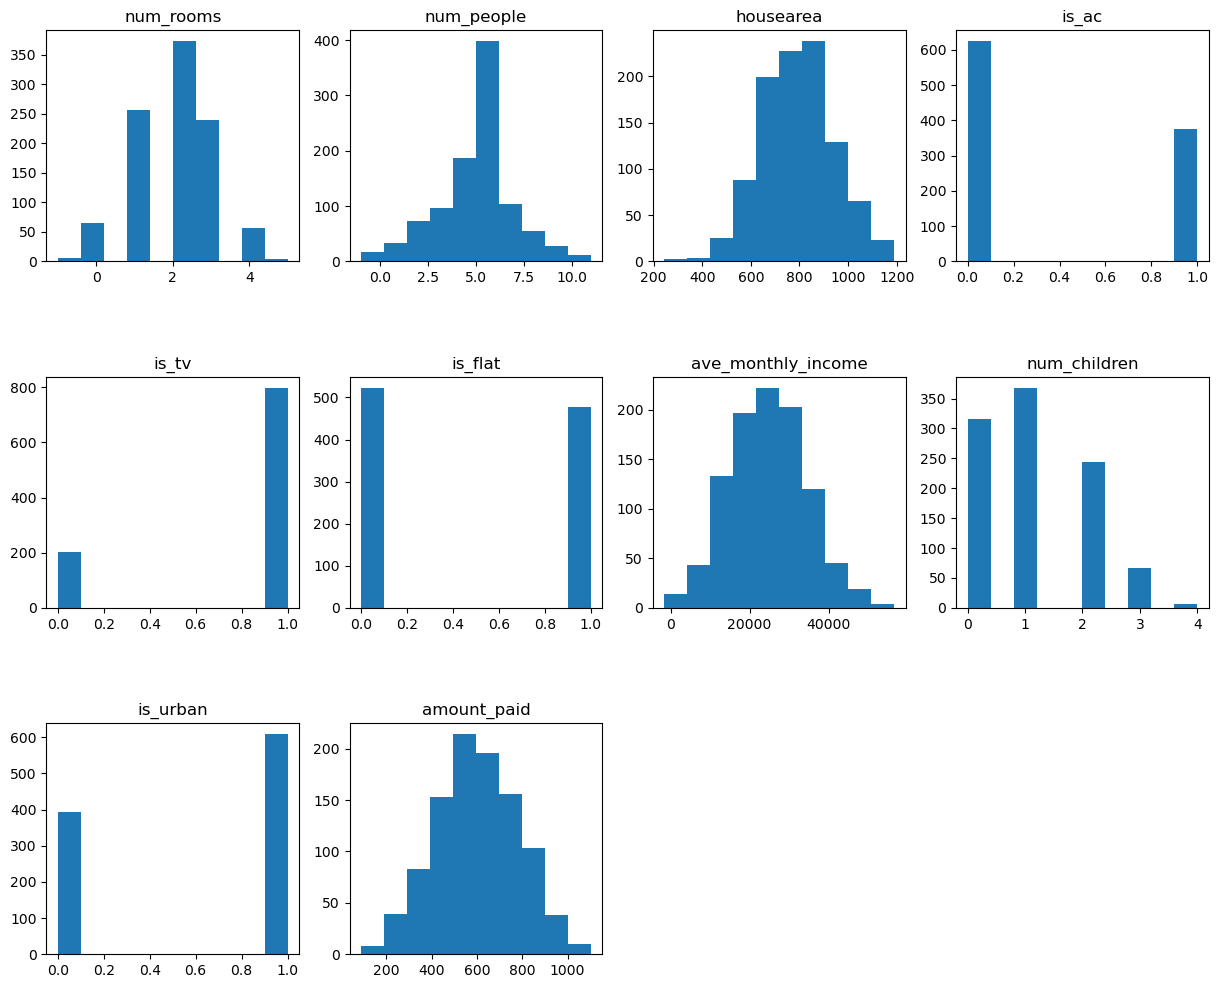

In [4]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

for i in range(len(data.columns)):
    plt.subplot(3, 4, i+1)
    plt.hist(data.iloc[:, i])
    plt.title(data.columns[i])

In [5]:
# 'num_rooms' & 'num_people' cannot be -ve or zero.
data.loc[data['num_rooms'] <= 0, 'num_rooms'] = round(data['num_rooms'].mean())
data.loc[data['num_people'] <= 0, 'num_people'] = round(data['num_people'].mean())

# 'ave_monthly_income' has -ve values too
data.loc[data['ave_monthly_income'] < 0, 'ave_monthly_income'] = data['ave_monthly_income'].mean()

In [6]:
from sklearn.model_selection import train_test_split

x = data.iloc[:, :-1]
y = data.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=11)

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

import numpy as np

In [8]:
lr = LinearRegression()
ridge = Ridge(random_state=11)
lasso = Lasso(random_state=11)
dtree = DecisionTreeRegressor(random_state=11)
rf = RandomForestRegressor(random_state=11)
xgb = XGBRegressor(random_state=11)

grid_ridge = GridSearchCV(ridge,
                      {'alpha' : [0, .25, .5, .75, 1]},
                      cv = 10)

grid_lasso = GridSearchCV(lasso,
                       {'alpha' : [.1, .25, .5, .75, 1]},
                        cv=10)

grid_dtree = GridSearchCV(dtree,
                        {'max_depth' : np.arange(8, 20, 2).tolist(),
                         'min_weight_fraction_leaf' : [.05, .1, .15, .2],
                         'max_leaf_nodes' : np.arange(10, 110, 10).tolist()},
                         cv = 10)

grid_rf = GridSearchCV(rf,
                        {'n_estimators': np.arange(180, 230, 10).tolist(),
                         'max_depth' : np.arange(80, 130, 10).tolist(),
                         'min_weight_fraction_leaf' : [.05, .1, .15],
                         'max_leaf_nodes' : np.arange(20, 45, 5).tolist()},
                        cv = 10)

grid_xgb = GridSearchCV(xgb,
                        {'eta' : [.05, .1, .15, .2],
                         'max_depth' : np.arange(6, 16, 2).tolist(),
                         'min_child_weight' : np.arange(16, 26, 2).tolist(),
                         'subsample' : [.4, .5, .6],
                         'colsample_bytree' : [.4, .5, .6]},
                        cv = 10)

In [9]:
lr.fit(x_train.values, y_train.values)
print("Done")

grid_ridge.fit(x_train.values, y_train.values)
print("Done")

grid_lasso.fit(x_train.values, y_train.values)
print("Done")

# grid_dtree.fit(x_train, y_train)
print("Done")

# grid_rf.fit(x_train, y_train)
print("Done")

# grid_xgb.fit(x_train, y_train)
print("Done")

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")

Done
Done
Done
Done
Done
Done


In [11]:
y_pred = lr.predict(x_test.values)
score_lr = r2_score(y_test, y_pred)

scores = {
    'linear': score_lr,
    'ridge': grid_ridge.cv_results_['mean_test_score'].max(),
    'lasso': grid_lasso.cv_results_['mean_test_score'].max(),
    'dtree': grid_dtree.cv_results_['mean_test_score'].max(),
    'rf': grid_rf.cv_results_['mean_test_score'].max(),
    'xgb': grid_xgb.cv_results_['mean_test_score'].max()
}

Text(0, 0.5, 'Accuracy')

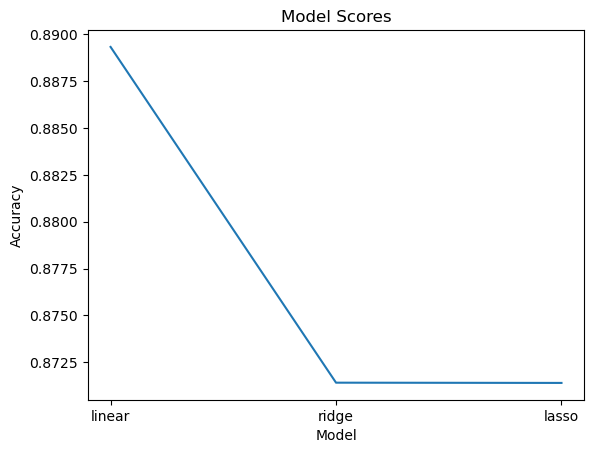

In [12]:
score_val = [scores[i] for i in scores]
score_name = [i for i in scores]

plt.plot(score_name, score_val)
plt.title("Model Scores")
plt.xlabel("Model")
plt.ylabel("Accuracy")

In [13]:
# Clearly, Linear, Ridge, & Lasso are the best.

#Create a Dataframe with the results of the search
results_R = pd.DataFrame(grid_ridge.cv_results_).sort_values('mean_test_score',
                                                         ascending = False)

#Keep only the parameter tested and its score
results_R = results_R[['param_alpha', 'mean_test_score']]

#Show the results
print(f"*** Ridge Regression ***\n{results_R}")


#Create a Dataframe with the results of the search
results_La = pd.DataFrame(grid_lasso.cv_results_).sort_values('mean_test_score',
                                                           ascending = False)

#Keep only the parameter tested and its score
results_La = results_La[['param_alpha', 'mean_test_score']]

#Show the results
print(f"\n*** Lasso Regression ***\n{results_La}")

*** Ridge Regression ***
  param_alpha  mean_test_score
4           1         0.871417
3        0.75         0.871416
2         0.5         0.871412
1        0.25         0.871405
0           0         0.871395

*** Lasso Regression ***
  param_alpha  mean_test_score
0         0.1         0.871404
1        0.25         0.871391
2         0.5         0.871298
3        0.75         0.871116
4           1         0.870845


In [14]:
#Create the estimators with the best parameters
ridge_final = Ridge(alpha = 1, random_state = 11)
lasso_final = Lasso(alpha = .1, random_state = 11)
lr_final = LinearRegression()

#Train the models using the train data
ridge_final.fit(x_train.values, y_train.values)
lasso_final.fit(x_train.values, y_train.values)
lr_final.fit(x_train.values, y_train.values)

#Create prediction values using the test data
ridge_predict = ridge_final.predict(x_test.values)
lasso_predict = lasso_final.predict(x_test.values)
lr_predict = lr_final.predict(x_test.values)

#Evaluate the predictions with R^2
ridge_score = r2_score(y_test, ridge_predict)
lasso_score = r2_score(y_test, lasso_predict)
lr_score = r2_score(y_test, lr_predict)

#Group the scores and the model names
bar_x = ['Ridge', 'Lasso', 'Linear']
bar_y = [ridge_score * 100, lasso_score * 100, lr_score * 100]

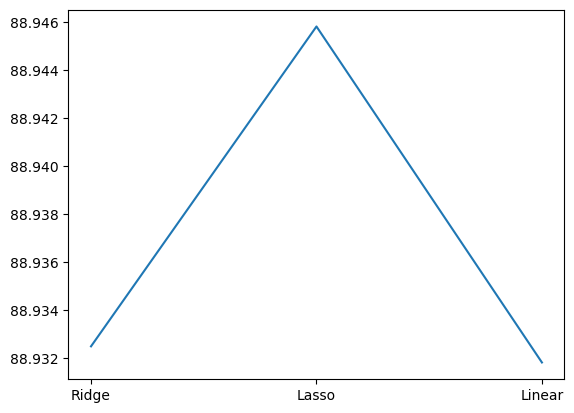

In [15]:
plt.plot(bar_x, bar_y)
plt.show()

In [16]:
# Lasso is the best model

y_pred = lasso_final.predict(x_test.values)
y_test = np.array(y_test)

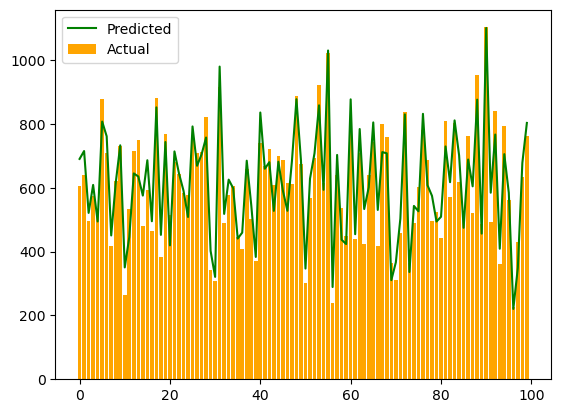

In [17]:
plt.plot(range(len(y_pred)), y_pred, color='green')
plt.bar(range(len(y_pred)), y_test, color='orange')

plt.legend(['Predicted', 'Actual'])
plt.xlabel("Index Number")
plt.ylabel("Predicted Bill Amount (in Rs.)")

In [18]:
import pickle

pickle.dump(lasso_final, open('model.pkl', 'wb'))

In [ ]:
# NOTE: If you are scaling the data, then make sure you 'Pickle' the 'StandardScaler' object, and use its 
# 'transform' function to transform the New Input Data to be Predicted.

# When you perform PCA, then save th